In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
sns.set_style('whitegrid')
import os.path
from astropy.io import fits
import ml_functions as ml
import data_prep as prep
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
seed=1212

This notebook is intended to run a specified number of machine learning algorithms on WASP data with the goal of classifying the data. More can be added in the ml_functions file. Note that it is assumed that all parameters for the algorithms have already been determined (this doesn't optimize them individually), so that need to be done ahead of time.

The input is in two parts. The first input is a dataset contianing all dispositioned stars in the WASP Hunter database. Each star has a variety of desciptive data about the star and the best-fit secondary transitor as determined by the BLS algorithm. It also includes the results of an mcmc parameter fit. This data is used for the majority of machine learning algorithms, including the Random Forest and logistic regression. Additional features can be added to the existing data.

The second input is a dataset containing the binned lightcurve data. This notebook does not do this step, so it is assumed that any input data is already prepared. In this case, I have 3 different binned arrays for each star: the full lightcurve, the 'local' lightcurve, ie a zoomed in view of the transit itself, and the periodogram. In this case the full lightcurves and periodograms are binned to a length of 500 and the local transits are binned to a length of 200. 

# Part 1: Prepare the data

The input dataset contains all dispositioned stars and all features returned with a database query. From this, we can curate the features and add additional information as needed. Note that many ML algorithms can't handle missing data (NaNs), so missing values are dealt with using the criteria listed below. 

In [3]:
data1 = pd.read_csv('training_set_Nov26_2019.csv', index_col=0)
print(data1.keys())
data1.head()

Index(['field', 'camera_id', 'tag', 'period', 'flag', 'npts_good', 'ntrans',
       'delta_chisq', 'sn_red', 'sn_ellipse', 'sn_anti', 'wchisq', 'period.1',
       'epoch', 'depth', 'width', 'pmatch_all', 'vmag', 'teff_jh', 'rstar_jh',
       'rpmj', 'rpmj_diff', 'giant_flag', 'jh_mcmc', 'rstar_mcmc',
       'mstar_mcmc', 'rplanet_mcmc', 'prob_rp', 'dchisq_mr', 'prob_rb',
       'jmag-hmag', 'period_mcmc_err', 'npts_intrans', 'chisq_intrans',
       'clump_idx', 'flag.1', 'dilution_v', 'sde', 'Comments'],
      dtype='object')


,field,camera_id,tag,period,flag,npts_good,ntrans,delta_chisq,sn_red,sn_ellipse,...,prob_rb,jmag-hmag,period_mcmc_err,npts_intrans,chisq_intrans,clump_idx,flag.1,dilution_v,sde,Comments
SWASP ID,,,,,,,,,,,,,,,,,,,,,
1SWASP J000118.17-085534.6,OF0001-0824,300,ORCA_TAMTFA,5.215560,P,32842,23,-252.641,-11.04420,0.699150,...,1.000000,0.224000,0.000067,444,NaN,0.2,P,0,39.5839,9.0
1SWASP J000126.92+392301.7,OF2355+3656,100,ORCA_TAMTFA,1.217494,P,16925,68,-806.328,-15.36680,3.007200,...,1.000000,0.148000,0.000004,704,NaN,0.4,P,0,69.7885,14.0
1SWASP J000411.14-472138.2,OF0000-4328,200,ORCA_TAMTFA,3.425280,P,13135,19,-128.025,-12.07590,0.921996,...,0.346667,0.330999,0.000045,141,NaN,0.2,P,0,19.6695,15.0
1SWASP J001550.81+011201.5,OF0032-0010,300,ORCA_TAMTFA,2.718633,P,21515,32,-608.123,-21.56400,0.468653,...,0.994667,0.255000,0.000011,381,NaN,0.2,P,0,62.2052,14.0
1SWASP J001635.09-105834.9,OF0001-0824,300,ORCA_TAMTFA,1.566978,P,9648,29,-126.506,-8.13421,1.051560,...,1.000000,0.221001,0.000033,352,NaN,0.2,P,0,23.9138,8.0


In [4]:
#Handling missing data
print(data1.isnull().sum())
#Since only 2 stars are missing jmag-hmag, I'll get rid of those. 
data1 = data1.dropna(subset=['jmag-hmag'])

field                  0
camera_id              0
tag                    0
period                 0
flag                   0
npts_good              0
ntrans                 0
delta_chisq            0
sn_red                 0
sn_ellipse             0
sn_anti                0
wchisq             10186
period.1               0
epoch                  0
depth                  0
width                  0
pmatch_all          2733
vmag                   0
teff_jh                0
rstar_jh               0
rpmj                   0
rpmj_diff              0
giant_flag             0
jh_mcmc            10186
rstar_mcmc          1899
mstar_mcmc          1899
rplanet_mcmc        1899
prob_rp             1899
dchisq_mr           1899
prob_rb             1899
jmag-hmag              2
period_mcmc_err     1899
npts_intrans           0
chisq_intrans      10186
clump_idx              0
flag.1                 0
dilution_v             0
sde                    0
Comments            2460
dtype: int64


In [5]:
data1['teff_jh'] = prep.get_temp(data1)
data1['rstar_jh'] = prep.get_rstar_jh(data1)
data1['mstar_jh'] = prep.get_mstar_jh(data1)

In [6]:
#More data handling:

#Stars with no rstar_mcmc value will get replaced with the rstar_jh
data1.rstar_mcmc.fillna(data1.rstar_jh, inplace=True)

#Stars with no mstar_mcmc value will get replaced with the mstar_jh value
data1.mstar_mcmc.fillna(data1.mstar_jh, inplace=True)

#Stars with no rplanet_mcmc will get replaced with sqrt(depth)*rplanet_mcmc
Rp_estimate = (np.sqrt(abs(data1['depth'])) * (data1['rstar_mcmc']*696000000.))/69900000. #Jupiter radii
data1.rplanet_mcmc.fillna(Rp_estimate, inplace=True)

#Stars with no period_mcmc_err will get replaced with the period*.00001
Perr_estimate = data1['period'] * 0.00001
data1.period_mcmc_err.fillna(Perr_estimate, inplace=True)


In [7]:
data1['delta_m'] = prep.get_delta_m(data1)
data1['rstar_Gaia'], data1['teff_Gaia'] = prep.get_gaia(data1)
data1['delta_GaiaR'] = prep.get_delta_Gaia(data1)
data1['trans_ratio'] = prep.get_trans_ratio(data1)
data1['near_int'] = prep.get_near_int(data1)
data1['rm_ratio'] = prep.get_rm_ratio(data1)
data1['depth_to_width'] = prep.get_depth_to_width(data1)
#Now all missing data is filled and can be used for ML

In [8]:
#Prepare the binned lightcurve and periodogram data for the CNN.
#Skip this if the data is already saved, as this is very time consuming.
#import binned_data as binning
#Just call the first one to see that it is working correctly. Then run on everything. 
#binned_pdgrm, binned_lc, binned_local = binning.get_binned_data(data1[0:1],  plot=True, get_pdgrm=True,get_full_lc=True, get_local_lc=True)
#binned_pdgrm, binned_lc, binned_local = binning.get_binned_data(data1,  plot=False, get_pdgrm=True,get_full_lc=True, get_local_lc=True)

#binned_pdgrm.to_csv('binned_pdgrm_Nov2019.csv')
#binned_lc.to_csv('binned_lc_Nov2019.csv')
#binned_local.to_csv('binned_local_Nov2019.csv')

In [9]:


features = ['period', 'flag', 'npts_good', 'ntrans','delta_chisq', 
            'sn_red','depth', 'width', 'vmag', 'teff_jh', 'rstar_jh',
            'rpmj', 'rpmj_diff', 'giant_flag', 'rstar_mcmc',
            'mstar_mcmc', 'rplanet_mcmc','jmag-hmag', 'period_mcmc_err', 
            'npts_intrans', 'clump_idx', 'dilution_v', 'sde',
            'delta_m','rstar_Gaia','delta_GaiaR','trans_ratio','near_int',
            'rm_ratio','depth_to_width']

data1 = data1[features]

print(data1.isnull().sum())

period             0
flag               0
npts_good          0
ntrans             0
delta_chisq        0
sn_red             0
depth              0
width              0
vmag               0
teff_jh            0
rstar_jh           0
rpmj               0
rpmj_diff          0
giant_flag         0
rstar_mcmc         0
mstar_mcmc         0
rplanet_mcmc       0
jmag-hmag          0
period_mcmc_err    0
npts_intrans       0
clump_idx          0
dilution_v         0
sde                0
delta_m            0
rstar_Gaia         0
delta_GaiaR        0
trans_ratio        0
near_int           0
rm_ratio           0
depth_to_width     0
dtype: int64


Now for the categories. We have 4 groups: 

P/EBLM - EBLMs are grouped with planets as they are often indistinguishable from planets by transit alone and are often interesting in their own right (such a brown dwarfs)

EB/Blend - Eclipsing binaries and 'blends', which are EBs diluted by multiple star's light

V - variable stars 

X - This cateogory has been defined differently by different groups, but in general is 'stuff that isn't transits'

In [10]:
transdict = {'EB':'EB/Blend','Blend':'EB/Blend','P':'P/EBLM','EBLM':'P/EBLM'} 
data1['flag'] = [transdict.get(i,i) for i in data1['flag']]
save_encoder = 'data_encoder.sav'

if os.path.isfile(save_encoder):
    le = joblib.load(save_encoder)
else:
    le = preprocessing.LabelEncoder()
    le.fit(data1['flag'])
    joblib.dump(le, save_encoder)

print(le.classes_)


Y_all = le.transform(data1['flag'])
Y_all = pd.DataFrame(data=Y_all, index=data1.index, columns=['True_val'])
data1 = data1.drop(['flag'], axis=1) #Drop the flag column so it is not a feature
Y_all.tail()

['EB/Blend' 'P/EBLM' 'V' 'X']


/Users/nschanch/anaconda2/envs/new_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,True_val
SWASP ID,
1SWASP J235613.20+374305.8,3
1SWASP J235801.26+374417.2,3
1SWASP J235847.43+412018.9,3
1SWASP J235915.10-384121.0,3
1SWASP J235926.09+420359.1,3


In [11]:
#Divide up the data into training and testing data
#Then get the scaling factors based on the training set
#Apply that scale factor to the test dataset too
X_all = data1.values
#Y_ will maintain the SWASP ID-true value pair
X, test_X, Y, test_Y = train_test_split(X_all, Y_all,  test_size=0.2, random_state=seed)

#Y = Y_['True_val'].values #Just the values themselves
#test_Y = test_Y_['True_val'].values

print(X.shape, test_X.shape)
print(Y.shape, test_Y.shape)

#Scale the data only using the training data(You can save the 'scaler' to use for future datasets)
#Scaler1 is for the numerical data
scaler1_file = 'Scaler1.sav'
if os.path.isfile(scaler1_file):
    scaler = joblib.load(scaler1_file)
else:
    scaler = preprocessing.MinMaxScaler().fit(X)
    joblib.dump(scaler, scaler1_file)
X = scaler.transform(X)
test_X = scaler.transform(test_X)

#Scaler2 is for the binned data for the CNN



(8147, 29) (2037, 29)
(8147, 1) (2037, 1)


# Part 2: Run all ML algorithms and get predictions

In [12]:
#Make a confusion matrix to show the results of any given predictor
def make_confusion(Y_true, Y_pred, tick_labels):
    #tick_labels in this case comes from le.classes_
    cmatrix = sklearn.metrics.confusion_matrix(Y_true, Y_pred, labels=None)
    #tick_labels = ['EB/Blend', 'P','V','X']
    #plt.xticks(tick_labels)
    plt.figure(figsize=(12,6))
    #try normalizing I guess
    plt.subplot(1,2,1)
    #plt.tight_layout()
    n_cmatrix = (cmatrix.astype('float') / cmatrix.sum(axis=1)[:,np.newaxis])*100
    sns.heatmap(n_cmatrix, annot=True, fmt='g',xticklabels=tick_labels, yticklabels=tick_labels, cbar=False, square=True, cmap="Blues", linewidth=0.1, linecolor='steelblue')
    plt.xlabel('Predicted class')
    plt.ylabel('WASP disposition')
    plt.title('Percent Correct Predictions')
    #plt.savefig('/Users/nschanch/st_andrews/figures/confusion_matrix_allBlend.eps')
    #plt.imshow(cmatrix, interpolation='nearest')
    #plt.xticks(np.arange(0,10), tick_labels)
    #plt.yticks(np.arange(0,10), tick_labels)


    #plt.figure(figsize=(6,6))
    #Normalize
    plt.subplot(1,2,2)
    sns.heatmap(cmatrix, annot=True, fmt='g',xticklabels=tick_labels, yticklabels=tick_labels, cbar=False, square=True, cmap="Blues", linewidth=0.1, linecolor='steelblue')
    plt.xlabel('Predicted class')
    plt.ylabel('WASP disposition')
    plt.title('True Number Correct Predictions')
    #plt.savefig('/Users/nschanch/st_andrews/Paper1/machine_learning/figures/RF_confusion_matrix.eps')

    plt.show()
    #plt.savefig('/Users/nschanch/st_andrews/figures/RF_confusion_matrix_allBlend.eps')


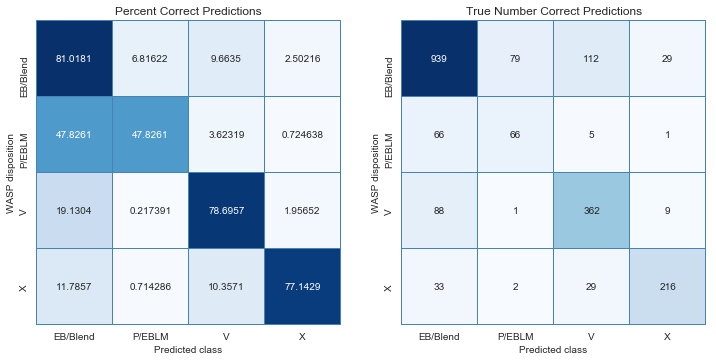

In [13]:
RF_pred = ml.run_RF(X,np.ravel(Y),test_X, optimize=True)
make_confusion(np.ravel(test_Y), RF_pred,le.classes_)

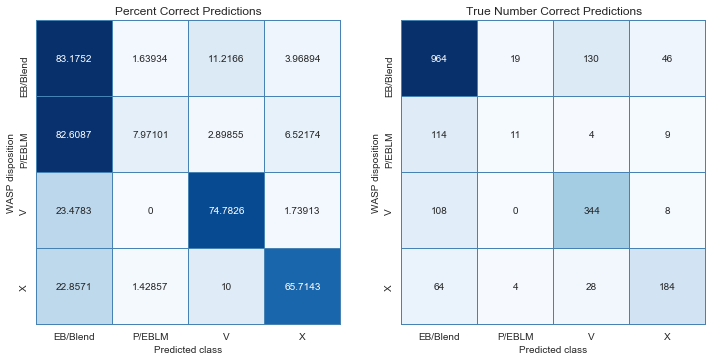

In [14]:
KNN_pred = ml.run_KNN(X,np.ravel(Y),test_X, optimize=True)
make_confusion(np.ravel(test_Y), KNN_pred,le.classes_)

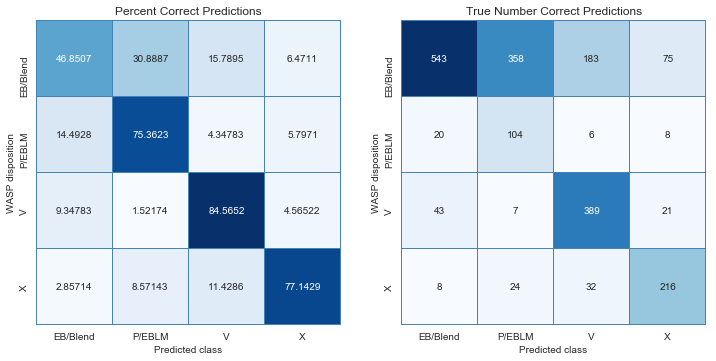

In [15]:
LR_pred = ml.run_LR(X,np.ravel(Y),test_X, optimize=True)
make_confusion(np.ravel(test_Y), LR_pred,le.classes_)

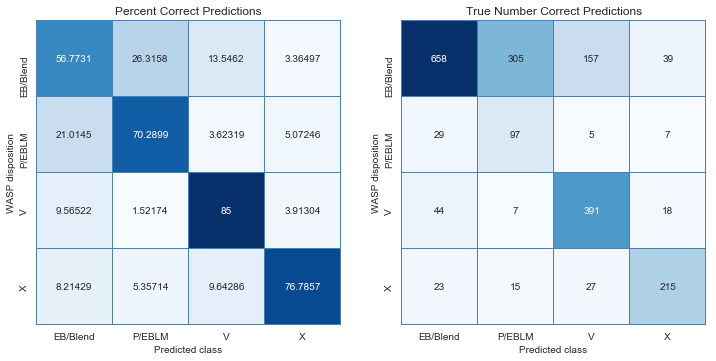

In [16]:
SVC_pred = ml.run_SVC(X,np.ravel(Y),test_X, optimize=True)
make_confusion(np.ravel(test_Y), SVC_pred,le.classes_)

# Part 3: CNN

In [17]:
data2_lc = pd.read_csv('binned_lc_Nov2019.csv', index_col=0)
data2_local = pd.read_csv('binned_local_Nov2019.csv', index_col=0)
data2_pdgrm = pd.read_csv('binned_pdgrm_Nov2019.csv', index_col=0)

X2_lc = data2_lc[data2_lc.index.isin(Y.index)]
X2_local = data2_local[data2_local.index.isin(Y.index)]
X2_pdgrm = data2_pdgrm[data2_pdgrm.index.isin(Y.index)]

X2_lc_test = data2_lc[data2_lc.index.isin(test_Y.index)]
X2_local_test = data2_local[data2_local.index.isin(test_Y.index)]
X2_pdgrm_test = data2_pdgrm[data2_pdgrm.index.isin(test_Y.index)]


Y2 = Y.loc[X2_local.index] #Y-values to match the training data
test_Y2 = test_Y.loc[X2_local_test.index]

X2_local = preprocessing.minmax_scale(X2_local, axis=1)
X2_pdgrm = preprocessing.minmax_scale(X2_pdgrm, axis=1)
X2_local_test = preprocessing.minmax_scale(X2_local_test, axis=1)
X2_pdgrm_test = preprocessing.minmax_scale(X2_pdgrm_test, axis=1)
print(len(data2_lc), len(X2_lc))

8846 7070


In [18]:
#print(X2_lc.shape, X2_pdgrm.shape)
X2_train = np.stack((X2_lc.values, X2_pdgrm), axis=2)
X2_test = np.stack((X2_lc_test.values, X2_pdgrm_test), axis=2)


Using TensorFlow backend.


8 10 4 8
###########
(None, 500, 8)
(None, 125, 10)
(None, 1250)
###########
(None, 4)
Epoch 1/75
7070/7070 [==============================] - 8s 1ms/step - loss: 1.0920 - accuracy: 0.5731
Epoch 2/75
7070/7070 [==============================] - 8s 1ms/step - loss: 0.9121 - accuracy: 0.6298
Epoch 3/75
7070/7070 [==============================] - 7s 1ms/step - loss: 0.7704 - accuracy: 0.6953
Epoch 4/75
7070/7070 [==============================] - 7s 1ms/step - loss: 0.7170 - accuracy: 0.7204
Epoch 5/75
7070/7070 [==============================] - 7s 1ms/step - loss: 0.7047 - accuracy: 0.7298
Epoch 6/75
7070/7070 [==============================] - 7s 1ms/step - loss: 0.6863 - accuracy: 0.7405
Epoch 7/75
7070/7070 [==============================] - 7s 1ms/step - loss: 0.6745 - accuracy: 0.7385
Epoch 8/75
7070/7070 [==============================] - 7s 1ms/step - loss: 0.6541 - accuracy: 0.7528
Epoch 9/75
7070/7070 [==============================] - 8s 1ms/step - loss: 0.6590 - accuracy: 0.

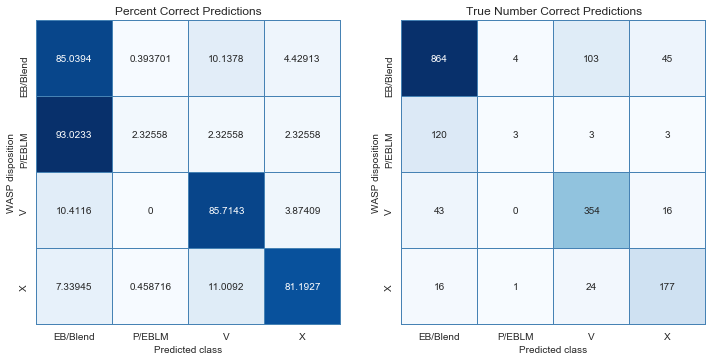

In [19]:
CNN_pred = ml.run_CNN(X2_train, np.ravel(Y2), X2_test, optimize=False)
make_confusion(np.ravel(test_Y2),CNN_pred,le.classes_)